# Architecture Image Classifier - Training

## Setup

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.5 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Data Collection

To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
# key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

Or, if you're comfortable at the command line, you can set it in your terminal with:

    export AZURE_SEARCH_KEY=your_key_here

and then restart Jupyter Notebook, and use the above line without editing it.

Once you've set `key`, you can use `search_images_bing`. This function is provided by the small `utils` class included with the notebooks online. If you're not sure where a function is defined, you can just type it in your notebook to find out:

In [ ]:
# search_images_bing

In [ ]:
# results = search_images_bing(key, 'contemporary architecture')
# ims = results.attrgot('contentUrl')
# len(ims)

In [ ]:
# #hide
# ims = ['https://th.bing.com/th/id/R.fcd1d4bfdcbb97b3cce3aad06bc7d87e?rik=hD0Eemi5etY36A&riu=http%3a%2f%2fmedia.architecturaldigest.com%2fphotos%2f5601b15b5a2d8a2712e8979b%2fmaster%2fpass%2fuk-modern-houses-book03.jpg&ehk=le0ak%2bz61ulWu38jG1bgW26HRJBV6NbQR6TzviRG5ZM%3d&risl=1&pid=ImgRaw&r=0']

In [ ]:
# dest = 'images/contemporary_home.jpg'
# download_url(ims[0], dest)

In [ ]:
# im = Image.open(dest)
# im.to_thumb(128, 128)

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [ ]:
architecture_types = 'contemporary', 'modern', 'traditional'
# path = Path('architecture')

In [ ]:
# if not path.exists():
#     path.mkdir()
#     for o in architecture_types:
#         dest = (path/o)
#         dest.mkdir(exist_ok=True)
#         results = search_images_bing(key, f'{o} architecture')
#         download_images(dest, urls=results.attrgot('contentUrl'))

`Personal Note:` Modify path for local copy of architecture data.

In [ ]:
path = Path('/content/gdrive/MyDrive/Colab Notebooks/Practical Deep Learning for Coders with fastai & PyTorch/Part 1/chap_2_project_architecture/architecture')

`Personal Note:` The following two code cells are used to download the images gathered from the previous code cell locally. This will reduce the number of times the Bing Search API will need to be called to amass the dataset, since Google Colab resets frequently.

In [ ]:
# !zip -r architecture.zip /content/architecture/

In [ ]:
# from google.colab import files
# files.download('architecture.zip')

## Data Cleaning

Our folder has image files, as we'd expect:

In [ ]:
fns = get_image_files(path)
fns

(#424) [Path('/content/gdrive/MyDrive/Colab Notebooks/Practical Deep Learning for Coders with fastai & PyTorch/Part 1/chap_2_project_architecture/architecture/modern/ecb12be9-9641-4c7f-882c-52d80800dc0b.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Practical Deep Learning for Coders with fastai & PyTorch/Part 1/chap_2_project_architecture/architecture/modern/897a0fb1-a6ce-4569-b640-a946ce043a60.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Practical Deep Learning for Coders with fastai & PyTorch/Part 1/chap_2_project_architecture/architecture/modern/3afd0d0e-b052-4eb4-927e-caf4ae48cc14.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Practical Deep Learning for Coders with fastai & PyTorch/Part 1/chap_2_project_architecture/architecture/modern/3c4c3069-8e4d-4e08-8743-2ec608d73fa6.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Practical Deep Learning for Coders with fastai & PyTorch/Part 1/chap_2_project_architecture/architecture/modern/b30053b5-4acf-403d-a4ce-174b63

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [ ]:
failed = verify_images(fns)
failed

(#0) []

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
failed.map(Path.unlink);

`Personal Note:` Test that `unlink` worked correctly.

In [ ]:
failed = verify_images(fns)
failed

(#0) []

## Data Loading

Later in the book you'll also learn about the `Dataset` and `Datasets` classes, which have the same relationship.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [ ]:
architectures = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables:

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [ ]:
dls = architectures.dataloaders(path)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

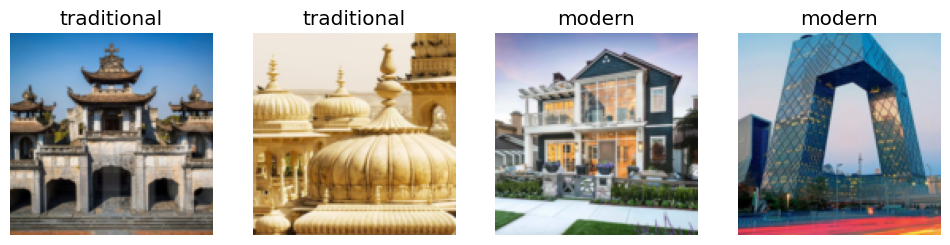

In [ ]:
# dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

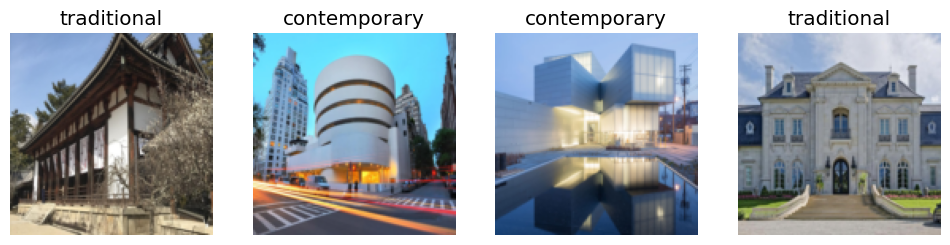

In [ ]:
# architectures = architectures.new(item_tfms=Resize(128, ResizeMethod.Squish))
# dls = architectures.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

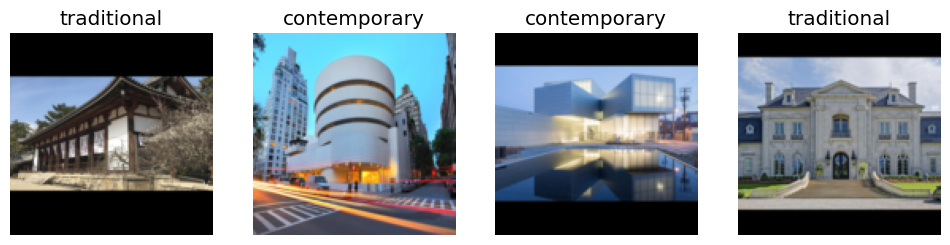

In [ ]:
# architectures = architectures.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
# dls = architectures.dataloaders(path)
# dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

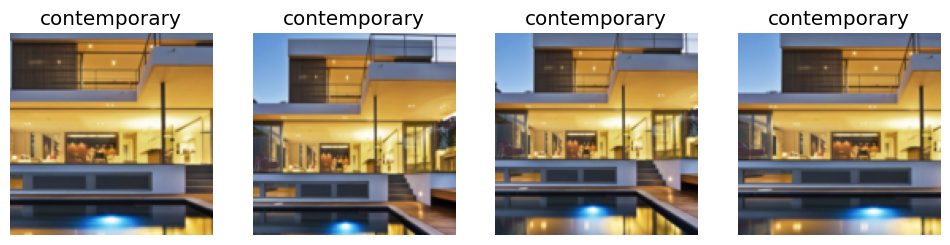

In [ ]:
# architectures = architectures.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
# dls = architectures.dataloaders(path)
# dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

## Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

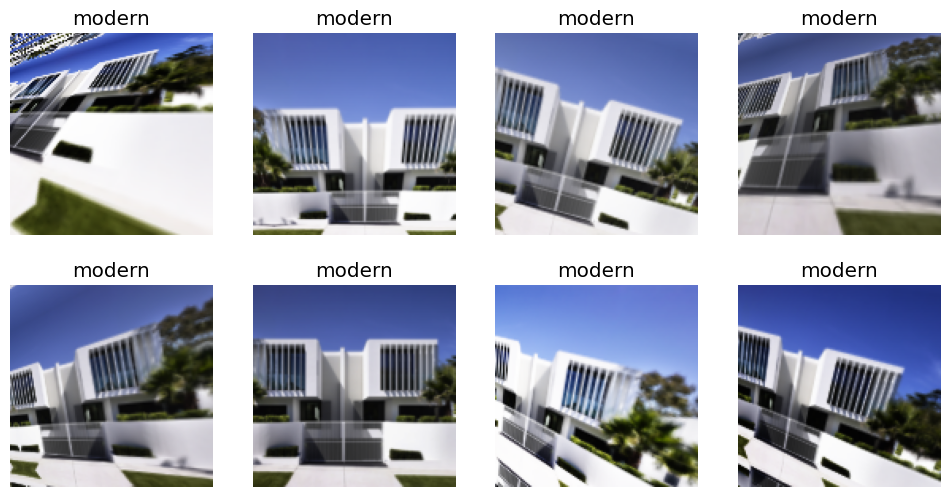

In [ ]:
# architectures = architectures.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
# dls = architectures.dataloaders(path)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Model Training

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [ ]:
architectures = architectures.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = architectures.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.724486,1.441462,0.511905,01:40


epoch,train_loss,valid_loss,error_rate,time
0,1.198873,1.167017,0.380952,02:09
1,1.055612,1.122765,0.357143,02:14
2,0.939585,1.128769,0.392857,02:08
3,0.859502,1.128562,0.380952,02:09


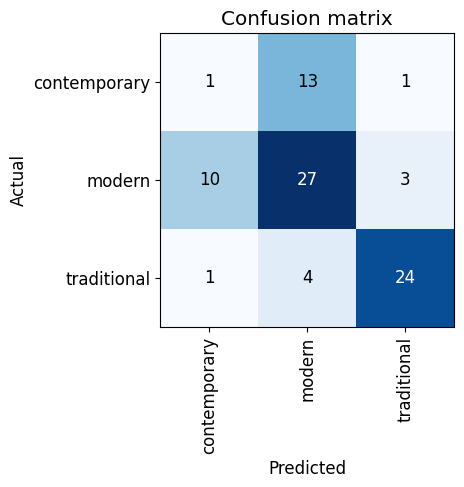

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

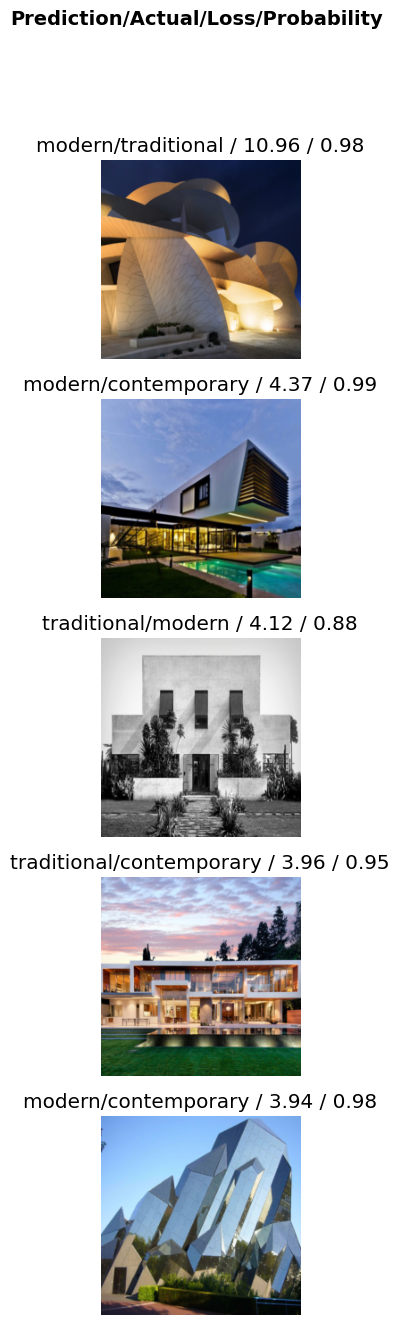

In [ ]:
interp.plot_top_losses(5, nrows=5)

This output shows that the image with the highest loss is one that has been predicted as "grizzly" with high confidence. However, it's labeled (based on our Bing image search) as "black." We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly."

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,building in cleaner.change():
  try:
    shutil.move(str(cleaner.fns[idx]), path/building)
  except:
    pass

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

In [ ]:
architectures = architectures.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = architectures.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.831173,1.041543,0.469880,02:04


epoch,train_loss,valid_loss,error_rate,time
0,1.155490,0.881419,0.445783,02:14
1,1.067281,0.811099,0.325301,02:11
2,0.975992,0.968207,0.289157,02:10
3,0.888654,0.992134,0.289157,02:08


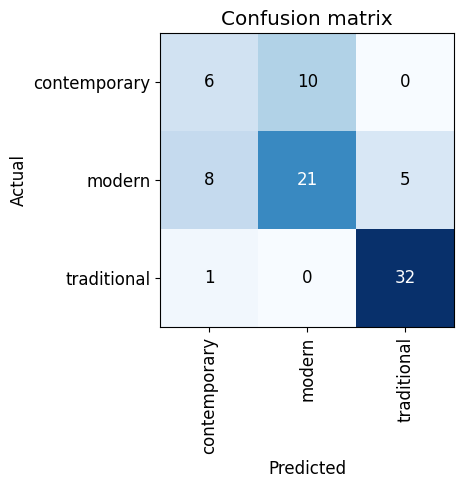

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()